### Read the diffsky LRG mocks at z = 0.5

In [9]:
from pathlib import Path
import numpy as np
import pandas
from cosmoprimo.cosmology import Cosmology
from acm import setup_logging
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


def read_diffsky(filename, apply_rsd=True, los='z',):
    # define cosmology
    boxsize = 1000
    redshift = 0.5
    cosmo = Cosmology(Omega_m=0.3089, h=0.6774, n_s=0.9667,
                      sigma8=0.8147, engine='class')  # UNIT cosmology
    hubble = 100 * cosmo.efunc(redshift)
    scale_factor = 1 / (1 + redshift)
    data = Table.read(filename)
    pos = data['pos']
    if apply_rsd:
        vel = data['vel']
        pos_rsd = (pos + vel / (hubble * scale_factor)) % boxsize
        los_dict = {'x': 0, 'y': 1, 'z': 2}
        pos[:, los_dict[los]] = pos_rsd[:, los_dict[los]]
    is_lrg = data["diffsky_isLRG"].astype(bool)
    return pos[is_lrg]

data_dir = '/global/cfs/cdirs/desicollab/users/gbeltzmo/C3EMC/UNIT'
data_fn = Path(data_dir) / 'galsampled_diffsky_mock_67120_fixedAmp_001_mass_conc_v0.3.hdf5'
diffsky_positions = read_diffsky(data_fn, apply_rsd=True, los='z')

### Let us begin by generating 100 HOD catalogs, sampled from the Yuan+21 priors.

In [2]:
from acm.hod import AbacusHOD

def get_hod_params(nrows=None):
    """Some example HOD parameters."""
    hod_dir = Path(f'/pscratch/sd/e/epaillas/emc/hod_params/yuan23/')
    hod_fn = hod_dir / f'hod_params_yuan23_c000.csv'
    df = pandas.read_csv(hod_fn, delimiter=',')
    df.columns = df.columns.str.strip()
    df.columns = list(df.columns.str.strip('# ').values)
    return df.to_dict('list')


# read example HOD parameters
hod_params = get_hod_params()

# load abacusHOD class
abacus = AbacusHOD(varied_params=hod_params.keys(),
                   sim_type='base', redshift=0.5,
                   cosmo_idx=0, phase_idx=0)

hod_positions = []
for i in range(20):
    hod = {key: hod_params[key][i] for key in hod_params.keys()}
    positions_dict = abacus.run(hod, nthreads=128)
    pos = np.c_[positions_dict['X'], positions_dict['Y'], positions_dict['Z_RSD']]
    hod_positions.append(pos)

Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation by slab,  20
Loading simulation by slab,  21
Loading simulation by slab,  22
Loading simulation by slab,  23
Loading simulation by slab,  24
Loading simulation by slab,  25
Loading simulation by slab,  26
Loading simulation by slab,  27
Loading simulation by slab,  28
Loading simulation by slab,  29
Loading simulation by slab,  30
Loading simulation

### Two-point correlation function

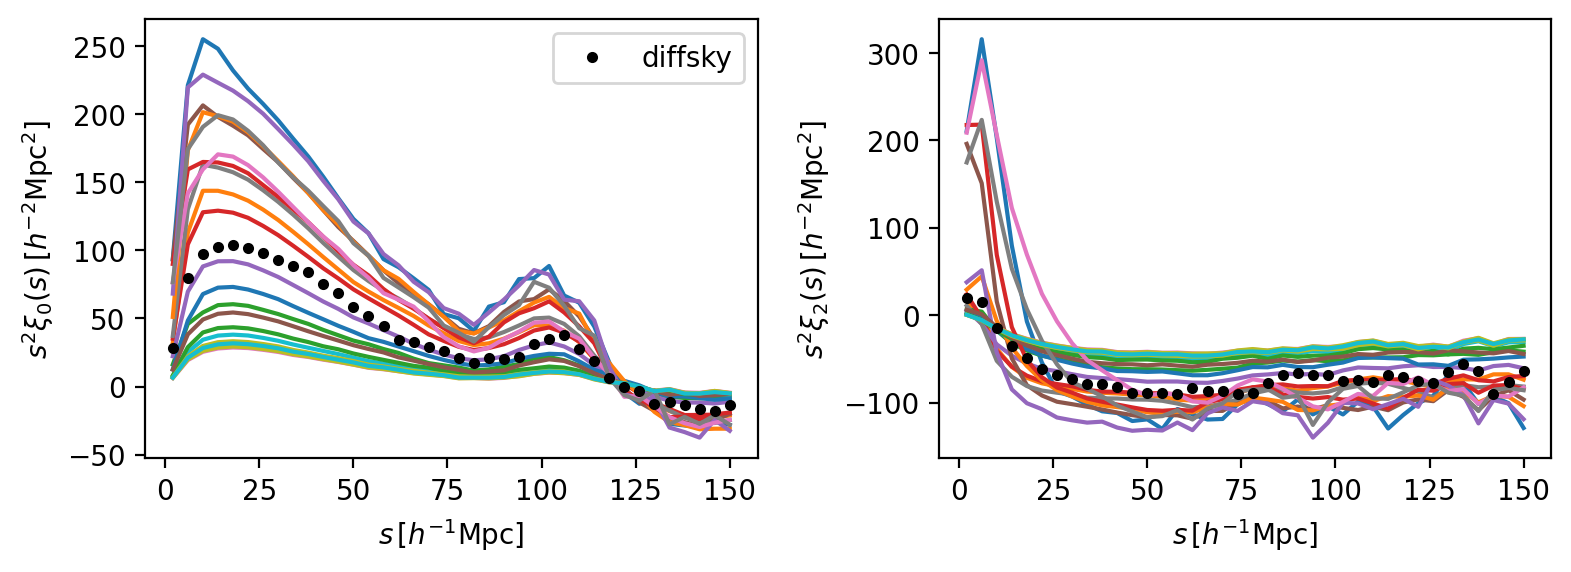

In [5]:
from pycorr import TwoPointCorrelationFunction

setup_logging(level='WARNING')

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

sedges = np.arange(0, 154, 4)
muedges = np.linspace(-1, 1, 241)
edges = (sedges, muedges)


for hod in hod_positions:
    result = TwoPointCorrelationFunction(mode='smu', boxsize=2000, edges=edges, data_positions1=hod,
                                         position_type='pos', los='z', nthreads=256, compute_sepsavg=False)
    s, multipoles = result(ells=(0, 2), return_sep=True)
    ax[0].plot(s, s**2*multipoles[0])
    ax[1].plot(s, s**2*multipoles[1])


result = TwoPointCorrelationFunction(mode='smu', boxsize=1000, edges=edges, data_positions1=diffsky_positions,
                                     position_type='pos', los='z', nthreads=256, compute_sepsavg=False)
s, multipoles = result(ells=(0, 2), return_sep=True)
ax[0].plot(s, s**2*multipoles[0], marker='o', ls='', label='diffsky', ms=3.0, color='k')
ax[1].plot(s, s**2*multipoles[1], marker='o', ls='', label='diffsky', ms=3.0, color='k')

ax[0].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[1].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$s^2 \xi_0(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[1].set_ylabel(r'$s^2 \xi_2(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[0].legend()
plt.tight_layout()

plt.show()
    

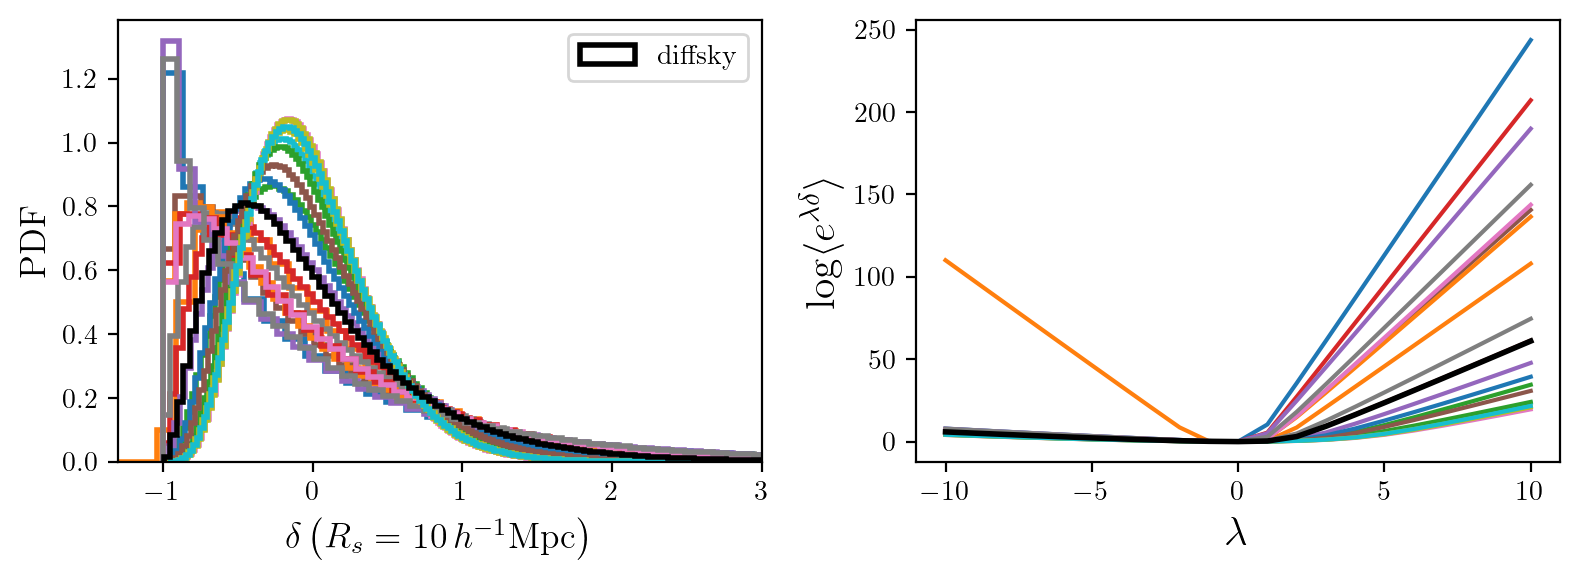

In [13]:
from acm.estimators.galaxy_clustering import DensityFieldCumulants
from acm import setup_logging

setup_logging(level='WARNING')

dc = DensityFieldCumulants(boxsize=2000, boxcenter=2000/2, cellsize=5.0)
lda = np.arange(-10, 11, 1)  # cumulant orders (lambdas)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for hod in hod_positions:
    dc.assign_data(positions=hod)
    dc.set_density_contrast(smoothing_radius=10)
    cgf = dc.compute_cumulants(lda)
    ax[0].hist(dc.delta_query, bins=200, density=True, lw=2.0, histtype='step')
    ax[1].plot(lda, cgf)
    
dc = DensityFieldCumulants(boxsize=1000, boxcenter=1000/2, cellsize=5.0)
lda = np.arange(-10, 11, 1)  # cumulant orders (lambdas)
dc.assign_data(positions=diffsky_positions, wrap=True)
dc.set_density_contrast(smoothing_radius=10)
cgf = dc.compute_cumulants(lda)
ax[0].hist(dc.delta_query, bins=200, density=True, lw=2.0, histtype='step', color='k', label='diffsky')
ax[1].plot(lda, cgf, lw=2.0, color='k', label='diffsky')
    
ax[0].set_xlabel(r'$\delta \left(R_s = 10\, h^{-1}{\rm Mpc}\right)$', fontsize=13)
ax[0].set_ylabel('PDF', fontsize=13)
ax[0].set_xlim(-1.3, 3.0)
ax[0].legend()
ax[1].set_xlabel(r'$\lambda$', fontsize=15)
ax[1].set_ylabel(r'$\log\langle e^{\lambda \delta}\rangle$', fontsize=15)
plt.tight_layout()
plt.show()

### Density split (configuration space)

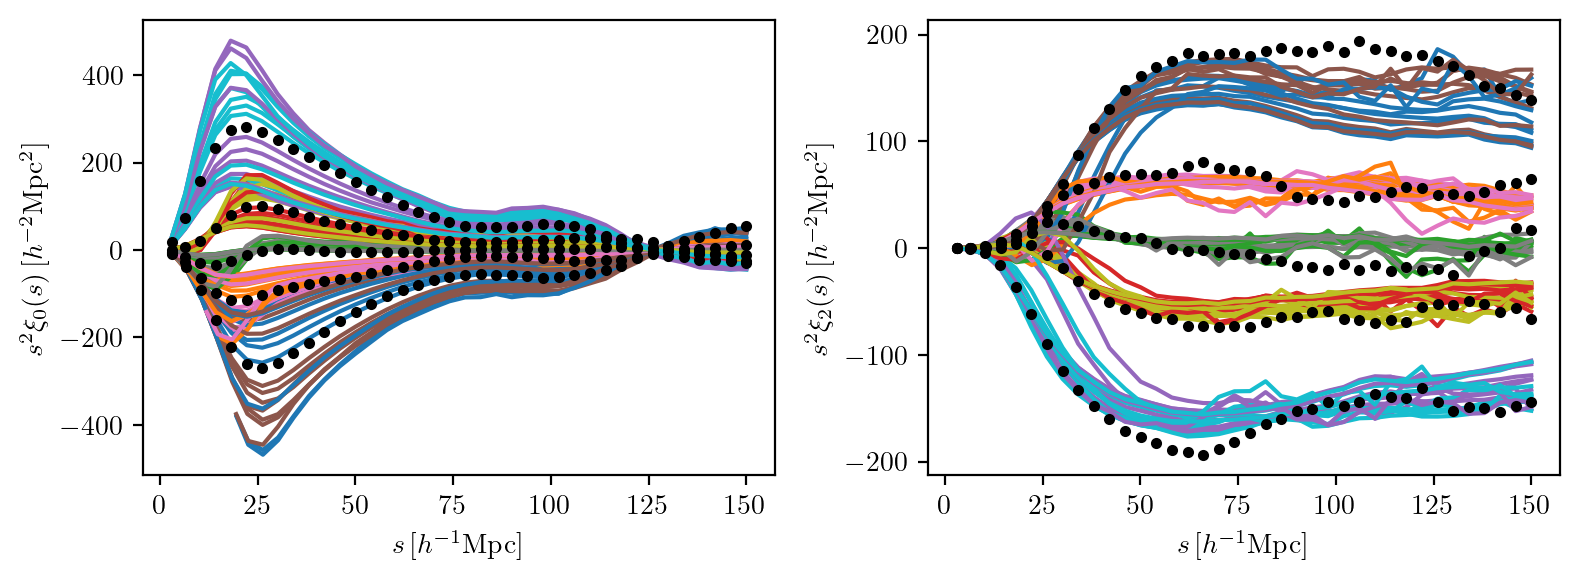

In [15]:
from acm.estimators.galaxy_clustering import DensitySplit

ds = DensitySplit(boxsize=2000, boxcenter=2000/2, cellsize=5.0)

sedges = np.arange(0, 154, 4)
muedges = np.linspace(-1, 1, 241)
edges = (sedges, muedges)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for hod in hod_positions:

    ds.assign_data(positions=hod, wrap=True, clear_previous=True)
    ds.set_density_contrast(smoothing_radius=10)
    ds.set_quantiles(nquantiles=5, query_method='randoms')
    results = ds.quantile_data_correlation(hod, edges=edges, los='z', nthreads=256)
    
    for result in results:
        s, multipoles = result(ells=(0, 2), return_sep=True)
        ax[0].plot(s, s**2*multipoles[0])
        ax[1].plot(s, s**2*multipoles[1])
    
    
ds = DensitySplit(boxsize=1000, boxcenter=1000/2, cellsize=5.0)
ds.assign_data(positions=diffsky_positions, wrap=True, clear_previous=True)
ds.set_density_contrast(smoothing_radius=10)
ds.set_quantiles(nquantiles=5, query_method='randoms')
results = ds.quantile_data_correlation(diffsky_positions, edges=edges, los='z', nthreads=256)
for result in results:
    s, multipoles = result(ells=(0, 2), return_sep=True)
    ax[0].plot(s, s**2*multipoles[0], marker='o', ls='', ms=3.0, color='k')
    ax[1].plot(s, s**2*multipoles[1], marker='o', ls='', ms=3.0, color='k')

    
ax[0].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[1].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$s^2 \xi_0(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[1].set_ylabel(r'$s^2 \xi_2(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.tight_layout()
plt.show()

### Density split (Fourier space)

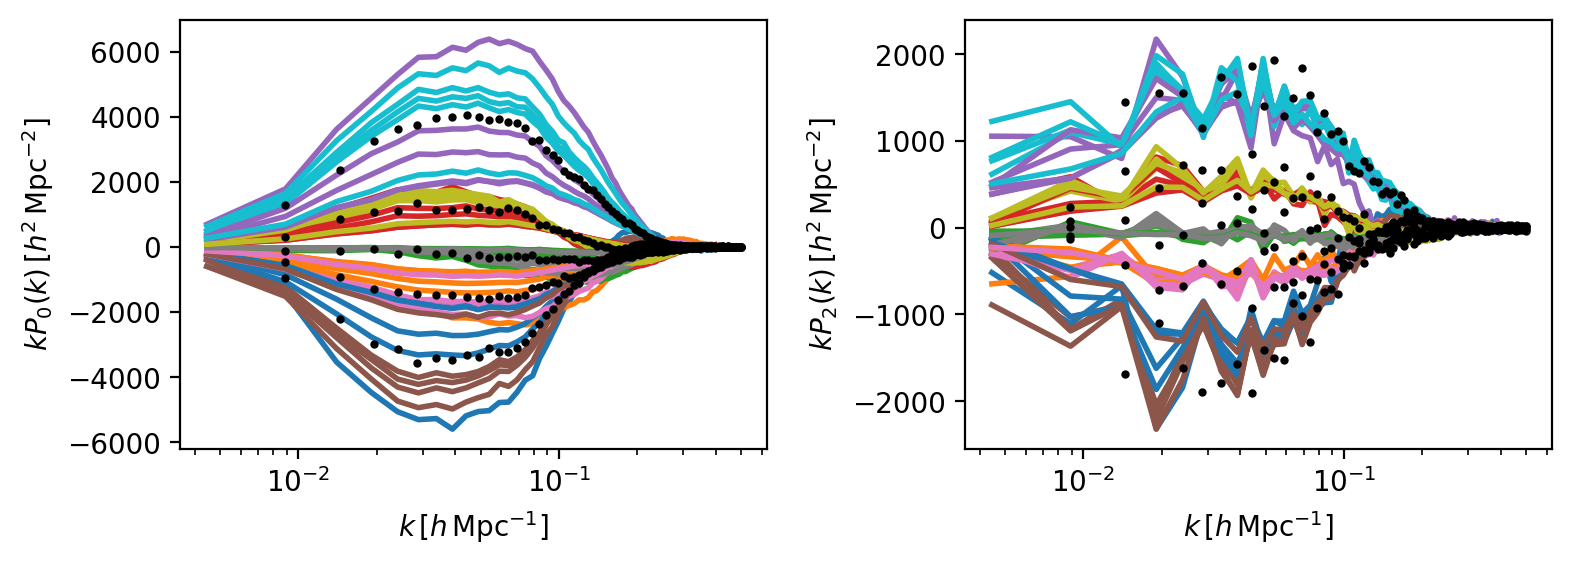

In [46]:
from acm.estimators.galaxy_clustering import DensitySplit

ds = DensitySplit(boxsize=2000, boxcenter=2000/2, cellsize=5.0)

edges = np.linspace(0.001, 0.5, 100)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for hod in hod_positions[:10]:

    ds.assign_data(positions=hod, wrap=True, clear_previous=True)
    ds.set_density_contrast(smoothing_radius=10)
    ds.set_quantiles(nquantiles=5, query_method='randoms')
    results = ds.quantile_data_power(hod, edges=edges, los='z', nmesh=256)
    
    for result in results:
        k, poles = result(ell=(0, 2), return_k=True, complex=False)
        ax[0].plot(k, k * poles[0], lw=2.0)
        ax[1].plot(k, k * poles[1], lw=2.0)
    
    
ds = DensitySplit(boxsize=1000, boxcenter=1000/2, cellsize=5.0)
ds.assign_data(positions=diffsky_positions, wrap=True, clear_previous=True)
ds.set_density_contrast(smoothing_radius=10)
ds.set_quantiles(nquantiles=5, query_method='randoms')
results = ds.quantile_data_power(diffsky_positions, edges=edges, los='z', nmesh=256)
for result in results:
    k, poles = result(ell=(0, 2), return_k=True, complex=False)
    ax[0].plot(k, k * poles[0], lw=2.0, marker='o', ls='', color='k', ms=2.0)
    ax[1].plot(k, k * poles[1], lw=2.0, marker='o', ls='', color='k', ms=2.0)

    
ax[0].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
ax[1].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
ax[0].set_ylabel(r'$k P_0(k)\, [h^{2}\,{\rm Mpc}^{-2}] $')
ax[1].set_ylabel(r'$k P_2(k)\, [h^{2}\,{\rm Mpc}^{-2}] $')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
plt.tight_layout()
plt.show()

### Void-galaxy cross-correlation function

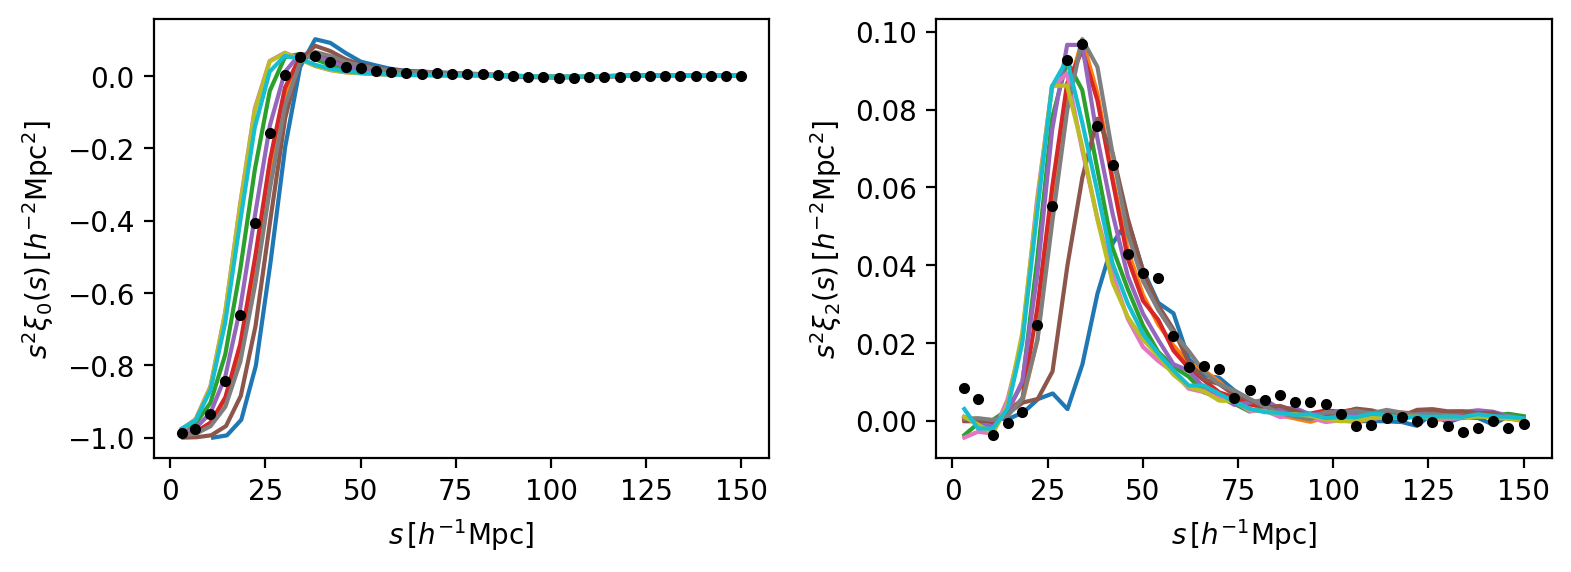

In [53]:
from acm.estimators.galaxy_clustering import VoxelVoids

voxel = VoxelVoids(boxsize=2000, boxcenter=2000/2, cellsize=5.0, temp_dir='/pscratch/sd/e/epaillas/tmp')

sedges = np.arange(0, 154, 4)
muedges = np.linspace(-1, 1, 241)
edges = (sedges, muedges)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for hod in hod_positions[:10]:

    voxel.assign_data(positions=hod)
    voxel.set_density_contrast(smoothing_radius=10)
    void_positions, void_radii = voxel.find_voids()
    result = voxel.void_data_correlation(hod, edges=edges, los='z', nthreads=256)
    
    s, multipoles = result(ells=(0, 2), return_sep=True)
    ax[0].plot(s, multipoles[0])
    ax[1].plot(s, multipoles[1])
    
    
voxel = VoxelVoids(boxsize=1000, boxcenter=1000/2, cellsize=5.0, temp_dir='/pscratch/sd/e/epaillas/tmp')
voxel.assign_data(positions=diffsky_positions, wrap=True)
voxel.set_density_contrast(smoothing_radius=10)
voxel.find_voids()
result = voxel.void_data_correlation(diffsky_positions, edges=edges, los='z', nthreads=256)
s, multipoles = result(ells=(0, 2), return_sep=True)
ax[0].plot(s, multipoles[0], marker='o', ls='', ms=3.0, color='k')
ax[1].plot(s, multipoles[1], marker='o', ls='', ms=3.0, color='k')
    
ax[0].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[1].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$s^2 \xi_0(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[1].set_ylabel(r'$s^2 \xi_2(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.tight_layout()
plt.show()

### Bispectrum


# Dimensions: [2.00e+03, 2.00e+03, 2.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.003, 0.003, 0.003] h/Mpc
# Nyquist frequency: [0.201, 0.201, 0.201] h/Mpc
# Pixel window: none
# Using fftw backend

Binning: 4 bins in [0.010, 0.090] h/Mpc
Squezed binning: 6 bins in [0.010, 0.130] h/Mpc
l-max: 2
N_bins: 78
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend

Binning: 4 bins in [0.010, 0.090] h/Mpc
Squezed binning: 6 bins in [0.010, 0.130] h/Mpc
l-max: 2
N_bins: 78
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


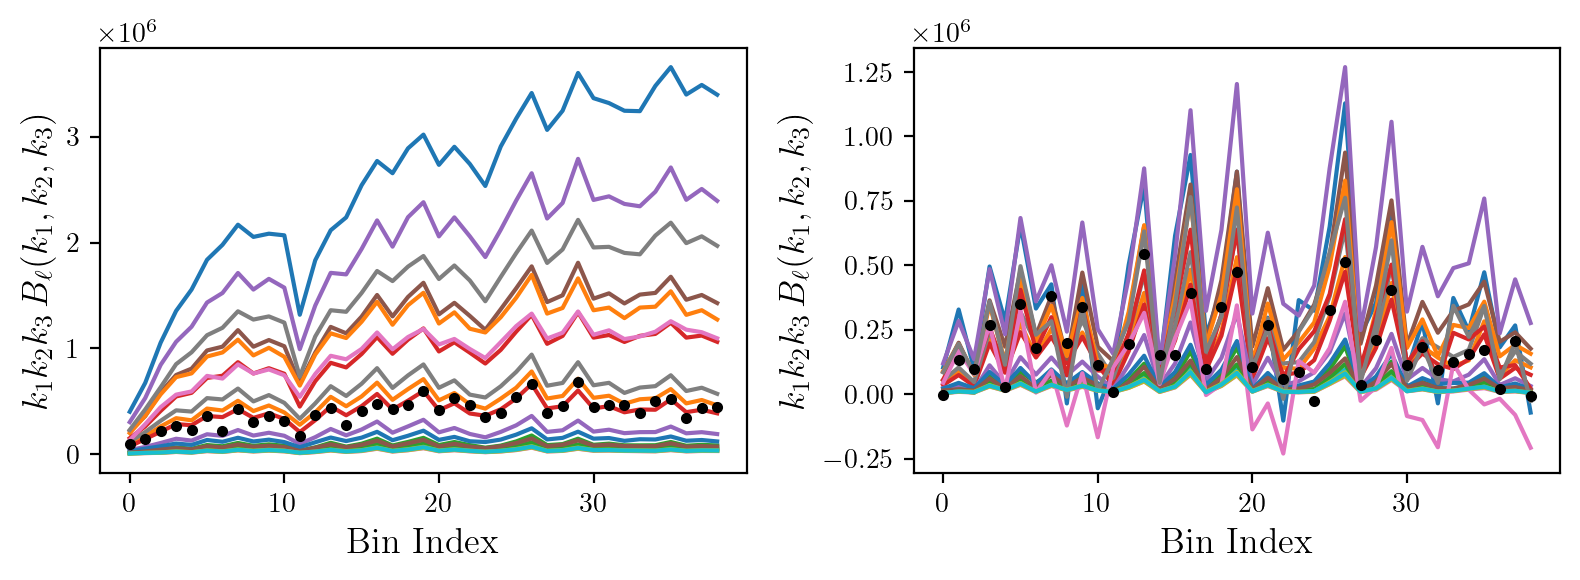

In [16]:
from acm.estimators.galaxy_clustering import Bispectrum

bspec = Bispectrum(boxsize=2000, boxcenter=0, nmesh=128,
                   sightline='global', nthreads=256)
    
bspec.set_binning(k_bins=np.arange(0.01, 0.10, 0.02), lmax=2,
                  k_bins_squeeze=np.arange(0.01, 0.15, 0.02),
                  include_partial_triangles=False)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for hod in hod_positions:

    bspec.assign_data(positions=hod, wrap=True)
    bspec.set_density_contrast()
    bk = bspec.Bk_ideal(discreteness_correction=False)
    k123 = bspec.get_ks()
    
    weight = k123.prod(axis=0)
    ax[0].plot(weight*bk['b0'])
    ax[1].plot(weight*bk['b2'])
    
    
bspec = Bispectrum(boxsize=1000, boxcenter=0, nmesh=128,
                   sightline='global', nthreads=256)
    
bspec.set_binning(k_bins=np.arange(0.01, 0.10, 0.02), lmax=2,
                  k_bins_squeeze=np.arange(0.01, 0.15, 0.02),
                  include_partial_triangles=False)
bspec.assign_data(positions=diffsky_positions, wrap=True)
bspec.set_density_contrast()
bk = bspec.Bk_ideal(discreteness_correction=False)
k123 = bspec.get_ks()

weight = k123.prod(axis=0)
ax[0].plot(weight*bk['b0'], marker='o', ls='', ms=3.0, color='k')
ax[1].plot(weight*bk['b2'], marker='o', ls='', ms=3.0, color='k')
    
    
ax[0].set_xlabel(r'Bin Index',fontsize=13)
ax[1].set_xlabel(r'Bin Index',fontsize=13)
ax[0].set_ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=13)
ax[1].set_ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=13)
plt.tight_layout()
plt.show()

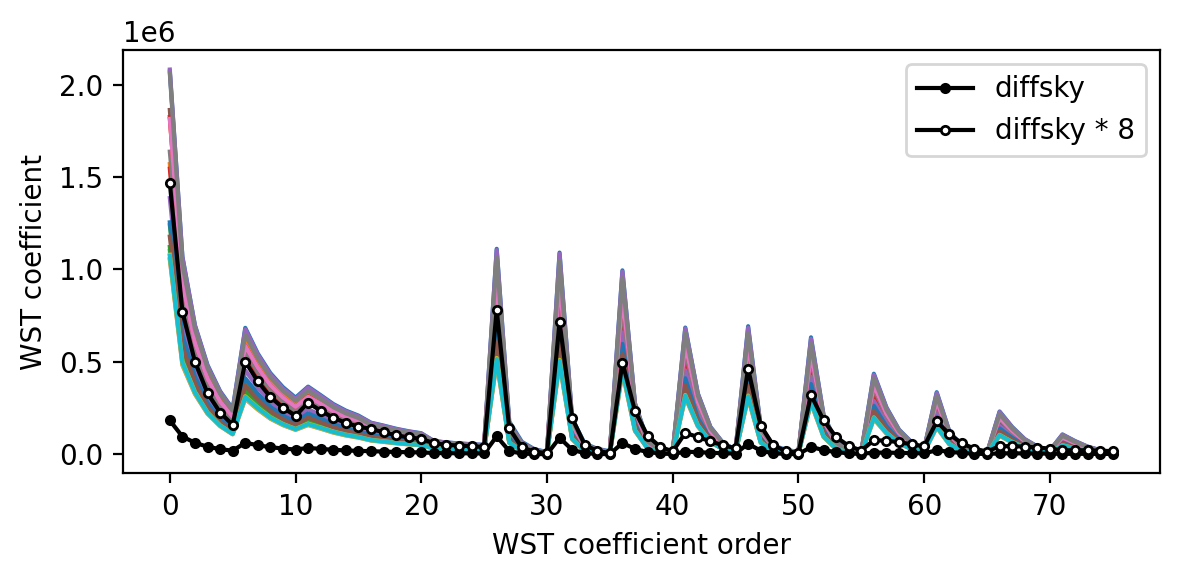

In [25]:
from acm.estimators.galaxy_clustering import WaveletScatteringTransform
from acm import setup_logging

setup_logging(level='WARNING')

# initialize the WST grid, using the random positions as a reference
wst = WaveletScatteringTransform(boxsize=2000, boxcenter=2000/2, cellsize=16.0)

fig, ax = plt.subplots(figsize=(6, 3))

for hod in hod_positions:
    wst.assign_data(positions=hod, wrap=True)
    wst.set_density_contrast()
    smatavg = wst.run()
    ax.plot(smatavg)
    
# initialize the WST grid, using the random positions as a reference
wst = WaveletScatteringTransform(boxsize=1000, boxcenter=1000/2, cellsize=16.0)
wst.assign_data(positions=diffsky_positions)
wst.set_density_contrast()
smatavg = wst.run()
ax.plot(smatavg, color='k', ms=3.0, marker='o', label='diffsky')
ax.plot(smatavg*8, color='k', ms=3.0, marker='o', markeredgewidth=1.0, markerfacecolor='w', label ='diffsky * 8')
    
ax.set_xlabel('WST coefficient order')
ax.set_ylabel('WST coefficient')
ax.legend()
plt.tight_layout()
plt.show()